Отборочное задание.
Требует opencv, numpy, matplotlib.pyplot, scikit-image, tqdm.
Предполагается расположение этого ноутбука в директории с кадрами.
Основано на коде https://github.com/Abdurrahheem/Camera-Trajectory-Estimation/blob/master/Camera%20Trajectory%20Estimation.ipynb .

In [24]:
# Переход между опроными точками
# https://github.com/nghiaho12/rigid_transform_3D
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is  3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return t, R

In [25]:
class Translation:
    def __init__(self):
        self.R = np.eye(3)
        self.t = np.zeros(3)

    def estimate(self, src, dst):
        self.t, self.R = rigid_transform_3D(src.T, dst.T)

    def residuals(self, src, dst):
        residuals = []
        for p1, p2 in zip(src, dst):
            diff = np.dot(self.R, p1) + self.t - p2
            residuals.append(np.linalg.norm(diff))

        return np.array(residuals)

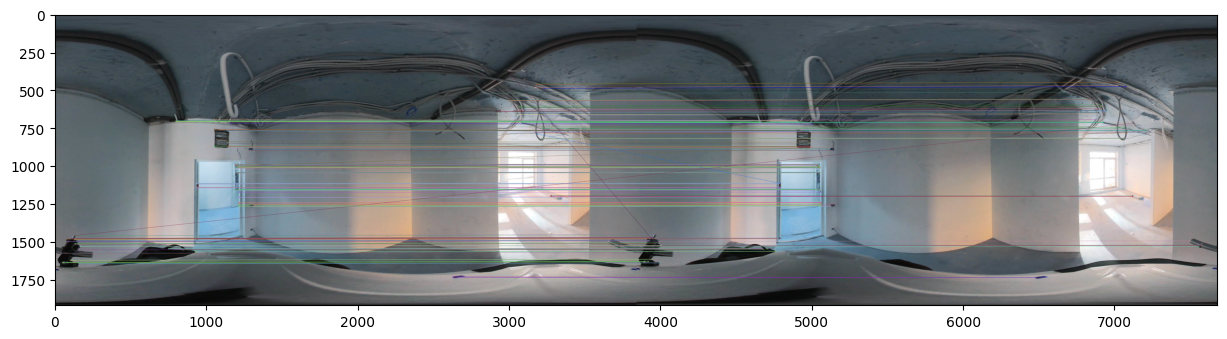

In [26]:
# Сопоставление опорных точек у первых двух кадров
import cv2
import numpy as np
import matplotlib.pyplot as plt

imageA = cv2.imread('frame0000250.jpg',cv2.IMREAD_UNCHANGED)
imageB = cv2.imread('frame0000251.jpg',cv2.IMREAD_UNCHANGED)
depthA = cv2.imread('frame0000250.jpg',cv2.IMREAD_UNCHANGED)
depthB = cv2.imread('frame0000251.jpg',cv2.IMREAD_UNCHANGED)

# ORB Detector
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(imageA, None)
kp2, des2 = orb.detectAndCompute(imageB, None)

# Brute Force Matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)

matching_result = cv2.drawMatches(imageA, kp1, imageB, kp2, matches, None, flags=2)


plt.figure(figsize=(15,15))
plt.imshow(matching_result)

In [27]:
# Определение координат
def to_real(x,y,z):
    A = np.asarray([[612.0, 0.0, 328.467896], [0.0, 612.0, 247.233337], [0.0, 0.0, 1.0]])
    return (z*np.linalg.inv(A)@np.asarray([x,y,1]))

In [28]:
x, y = kp1[1].pt
z = depthA[int(y),int(x)]
print(to_real(x,y,z))

[ 13.29066889 104.01797332  90.        ]


In [29]:
# Функция определния вектора трансляции и вращения между парой кадров
def matchgen(n):
    
    imageA = cv2.imread('frame0000'+str(n)+'.jpg',cv2.IMREAD_UNCHANGED)
    imageB = cv2.imread('frame0000'+str(n+1)+'.jpg',cv2.IMREAD_UNCHANGED)
    depthA = cv2.imread('frame0000'+str(n)+'.jpg',cv2.IMREAD_UNCHANGED)
    depthB = cv2.imread('frame0000'+str(n+1)+'.jpg',cv2.IMREAD_UNCHANGED)

    # ORB Detector
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(imageA, None)
    kp2, des2 = orb.detectAndCompute(imageB, None)

    # Brute Force Matching
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    setA,setB = [],[]
    for match in matches[:200]:
        
        xa,ya = kp1[match.queryIdx].pt
        xb,yb = kp2[match.trainIdx].pt
        za = depthA[int(ya),int(xa)]
        zb = depthB[int(yb),int(xb)]
    
        if za.all()!=0 and zb.all()!=0:
            setA.append(list(map(int,to_real(xa,ya,za))))
            setB.append(list(map(int,to_real(xb,yb,zb))))

    return np.asarray(setA),np.asarray(setB)

In [39]:
from skimage.measure import ransac

SetA,SetB = matchgen(250)

R,t = ransac((SetA,SetB),
             Translation,
             min_samples=10, 
             residual_threshold=100
            )
R.R

array([[ 0.99999497,  0.00139252,  0.00285025],
       [-0.00137336,  0.99997652, -0.00671333],
       [-0.00285953,  0.00670939,  0.9999734 ]])

In [40]:
R.t

array([[-1.07736531],
       [ 1.1320818 ],
       [-0.93566966]])

In [53]:
from tqdm import tqdm_notebook

Rotation = []
Translat = []
count = 0

startFrame = 250
endFrame = 450
# 250-450 кадры
for n in tqdm_notebook(range(startFrame,endFrame)):

    try:
        
        SetA,SetB = matchgen(n)
        R,t = ransac((SetA,SetB),
                     Translation,
                     min_samples=10,
                     residual_threshold=100
                    )
# эмпирически выбранный диапазон, в котором меньше дисперсия значений
        if np.linalg.norm(R.t) < 7.5 and np.linalg.norm(R.t) > 1: 
            Rotation.append(R.R)
            Translat.append(R.t)
        
        
    except:
        print("Did not work this time")
        count += 1
#     print('Ration matrix: \n {} \n {}'.format(R,t))
Rotation = np.array(Rotation)
Translat = np.array(Translat)

/tmp/ipykernel_1457/2964809845.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(startFrame,endFrame)):


  0%|          | 0/200 [00:00<?, ?it/s]

det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for

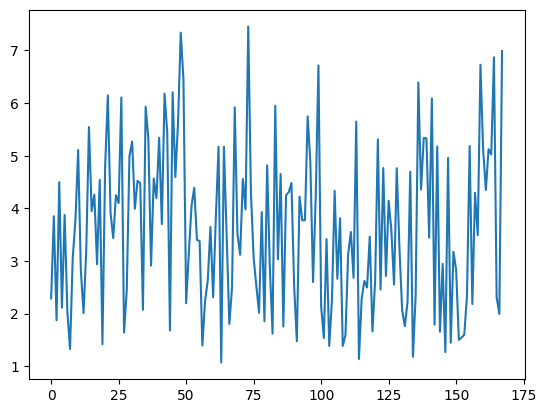

In [54]:
# нормированные вектора трасляции
norms = [np.linalg.norm(i) for i in Translat]
plt.plot(range(len(norms)), norms)

In [55]:
# Преобразование к координатной системе
Fullrotation= np.eye(3)
TransInCrdnt = []

for i in range(len(Rotation)):
    
    TransInCrdnt.append( Fullrotation@Translat[i].copy() )
#     Fullrotation = np.linalg.inv(Rotation[i].copy())@Fullrotation
    Fullrotation = Fullrotation@np.linalg.inv(Rotation[i].copy())
    
TransInCrdnt = np.squeeze( np.array(TransInCrdnt) )
TransInCrdnt.shape

(168, 3)

In [56]:
# Заполнение траектории камеры
traj = []
summ = np.array([0.,0.,0.])

for i in range(TransInCrdnt.shape[0]):
    traj.append(summ)
    summ = summ + TransInCrdnt[i]
    
traj = np.array(traj)
traj.shape

(168, 3)

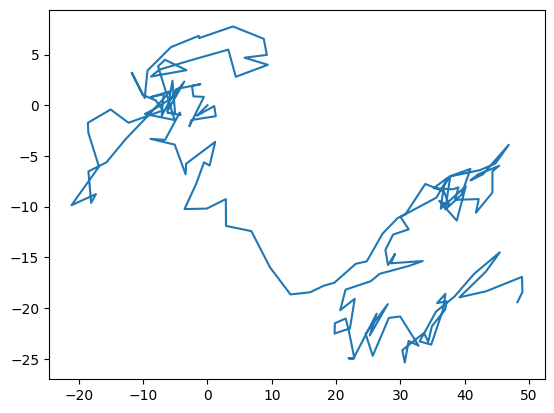

In [57]:
# Визуализация 1
plt.plot(traj[:,0], traj[:,2])

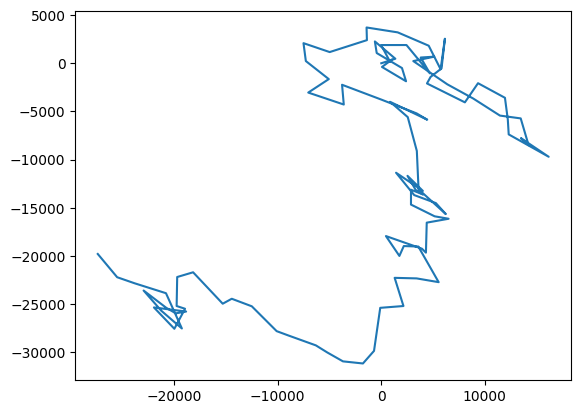

In [59]:
# Визуализация 2
A = np.asarray([[612.0, 0.0, 328.467896], [0.0, 612.0, 247.233337], [0.0, 0.0, 1.0]])
camtraj = (A@traj.T).T
plt.plot(-1*camtraj[:100,0],camtraj[:100,1])

In [60]:
# Экспорт траетории в формате .CSV
np.savetxt("sitecamera.csv", camtraj, delimiter=",")

In [62]:
# Подчеркивание граней помещения
img = cv2.imread("frame0000250.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#print(contours)
cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
cv2.imwrite("contours1.png", img)

True